In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
df = pd.read_pickle("2_merged_prolific_data_filtered.pickle")
df

,instance_id,mask,points_clicked,filename,answer,time_to_submit,prolific_session_id,nr_clicks,caption,foil,linguistic_phenomena,Approval,clip_pred_diff,img_path
0,20240209102845833682,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[(177.5, 226), (65.5, 275), (67.5, 283), (367....",000000057027.jpg,caption,76.445115,65c5fe51fd295062720c7d34,6,A baby elephant walks with an older elephant,A baby elephant walks past an older elephant,relations,Approve,0.524429,../VALSE_data/images/coco2017/000000057027.jpg
2,20240209102845833682,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[(92.5, 190), (158.5, 242), (201.5, 279)]",000000121506.jpg,caption,56.860392,65c5fe51fd295062720c7d34,3,An umbrella on a backyard patio is upturned fr...,An umbrella on a backyard patio is upturned in...,relations,Unsure,-0.236315,../VALSE_data/images/coco2017/000000121506.jpg
5,20240209102845833682,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[(213.5, 301), (310.5, 360)]",000000376307.jpg,caption,39.317548,65c5fe51fd295062720c7d34,2,The two women sit near the blender next to a t...,The two women sit in the blender next to a tab...,relations,Unsure,0.769114,../VALSE_data/images/coco2017/000000376307.jpg
6,20240209102845833682,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[(178.5, 199), (176.5, 191), (174.5, 193), (19...",000000378673.jpg,caption,109.436283,65c5fe51fd295062720c7d34,10,A man riding a skateboard down the side of a r...,A man riding a skateboard up the side of a ramp.,relations,Unsure,-0.272263,../VALSE_data/images/coco2017/000000378673.jpg
7,20240209102845833682,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[(176.5, 174), (192.5, 185), (211.5, 322), (21...",000000393093.jpg,caption,145.016043,65c5fe51fd295062720c7d34,10,The train is going over the busy urban bridge.,The train is going towards the busy urban bridge.,relations,Approve,0.183151,../VALSE_data/images/coco2017/000000393093.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,20240204143913560556,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[(146, 291), (119, 321), (103, 277), (216, 347...",v7w_2363335.jpg,caption,70.225968,65bf9f4014e422cb67a1ad0e,6,There is a mast on the closest boat.,There is no mast on the closest boat.,existence,Approve,-0.371067,../VALSE_data/images/v7w/v7w_2363335.jpg
541,20240204143913560556,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[(124, 307), (54, 99), (69, 174)]",v7w_2367084.jpg,caption,23.476451,65bf9f4014e422cb67a1ad0e,3,There is a giraffe.,There is no giraffe.,existence,Approve,1.729998,../VALSE_data/images/v7w/v7w_2367084.jpg
542,20240204143913560556,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[(206, 268), (91, 95), (317, 92), (201, 83), (...",v7w_2373121.jpg,caption,47.739632,65bf9f4014e422cb67a1ad0e,7,There are no clouds in the sky.,There is at least one cloud in the sky.,existence,Approve,0.784605,../VALSE_data/images/v7w/v7w_2373121.jpg
543,20240204143913560556,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[(178, 83), (160, 95), (252, 102), (322, 71), ...",v7w_2390850.jpg,caption,91.203454,65bf9f4014e422cb67a1ad0e,7,There are no people in the water.,There is at least one person in the water.,existence,Approve,0.839369,../VALSE_data/images/v7w/v7w_2390850.jpg


### Create normalized masks

1. Stretch all the values so that 1.0 becomes 0 and 255 stays 255. Mapping 1,255 to 0, 255
2. Normalize so that all the masks sum to 1

In [3]:
normalized_masks = []

for mask in df['mask']:
    mask = (mask-1)
    mask = mask / mask.sum()
    normalized_masks.append(mask)

df['mask_normalized'] = normalized_masks
df.head(1)

# save normalized masks to the PICKLE file

df.to_pickle("2_merged_prolific_data_filtered_normalized.pickle")


# Average the normalized masks, create a new dataframe with one row per stimulus
**Merging approach: Simple elementwise average of already-normalized arrays**

reduce the number of rows in a pandas dataframe by merging some information. Basically create a new dataframe that has the following:

1. filename (the original df has multiple of each, this one should have only one)
2. caption and foil (both are constant for a given filename)
3. nr_clicks should become a list of the different values for this filename
4. total_clicks should be the sum of nr_clicks
5. linguistic_phenomena is a constant for each filename
6. points_clicked is always a list. These lists should be fully merged for each filename
7. mask_normalized should be averaged -- this is a bunch of 2d arrays of the same size (numpy). These should be averaged element wise

In [4]:
combi_df = df.groupby('filename').agg({
    'img_path':'first',
    'mask_normalized': lambda x: np.mean(np.array(list(x)), axis=0), # average the masks
    'caption': 'first', # same for all the group
    'foil': 'first',
    'nr_clicks': lambda x: list(x),
    'linguistic_phenomena': 'first',
    'points_clicked': lambda x: [item for sublist in x for item in sublist], # create one whole list for points clicked
})

# Reset index to make 'filename' a column
combi_df.reset_index(inplace=True)
combi_df['total_clicks'] = [np.sum(nr_clicks) for nr_clicks in combi_df['nr_clicks']]

combi_df

,filename,img_path,mask_normalized,caption,foil,nr_clicks,linguistic_phenomena,points_clicked,total_clicks
0,000000001584.jpg,../VALSE_data/images/coco2017/000000001584.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","The red, double decker bus is driving past oth...","The red, double decker bus is driving towards ...","[4, 2, 2]",relations,"[(100, 204), (344, 270), (52, 228), (392, 227)...",8
1,000000005529.jpg,../VALSE_data/images/coco2017/000000005529.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",A person on skis is skiing down a snowy hill.,A person on skis is skiing up a snowy hill.,"[4, 2, 2, 3]",relations,"[(180, 246), (187, 201), (106, 258), (182, 107...",11
2,000000021903.jpg,../VALSE_data/images/coco2017/000000021903.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",A man reaches out to give the elephant something.,A man reaches inside to give the elephant some...,"[4, 3, 3, 2]",relations,"[(171.5, 230), (223.5, 238), (171.5, 214), (12...",12
3,000000027620.jpg,../VALSE_data/images/coco2017/000000027620.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",The laptop was left open on the desk.,The laptop was left open under the desk.,"[5, 4, 3]",relations,"[(146.5, 250), (295.5, 168), (45.5, 109), (306...",12
4,000000033368.jpg,../VALSE_data/images/coco2017/000000033368.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",A tennis player is standing on the court.,A tennis player is standing off the court.,"[1, 4, 4]",relations,"[(200.39996337890625, 126.19999694824219), (18...",9
...,...,...,...,...,...,...,...,...,...
87,v7w_2402139.jpg,../VALSE_data/images/v7w/v7w_2402139.jpg,"[[5.392276262310973e-06, 5.500667944166996e-06...",There are no clouds in the sky.,There is at least one cloud in the sky.,"[3, 6, 6]",existence,"[(176.5, 136), (237.5, 80), (77.5, 47), (352, ...",15
88,v7w_2407816.jpg,../VALSE_data/images/v7w/v7w_2407816.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",There is at least one power line.,There are no power lines.,"[5, 4, 4, 7]",existence,"[(196.5, 229), (344.5, 289), (47.5, 202), (354...",20
89,v7w_2411632.jpg,../VALSE_data/images/v7w/v7w_2411632.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",There are no people in the photo.,There is at least one person in the photo.,"[5, 9, 10, 10, 7]",existence,"[(224.5, 249), (245.5, 343), (248.5, 349), (16...",41
90,v7w_2411942.jpg,../VALSE_data/images/v7w/v7w_2411942.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",There is at least one zebra in the picture.,There are no zebras in the picture.,"[4, 3, 2, 2]",existence,"[(172, 200), (316, 307), (245, 150), (192, 165...",11


# Create 4x4 downsampled version

In [5]:
# see shape of the masks
for mask in combi_df.mask_normalized[:4]:
    print(mask.shape)

(400, 400)
(400, 400)
(400, 400)
(400, 400)


In [6]:
import numpy as np

def downsample(mask):
    """Downsample normalized 400x400 mask to 4x4 by summing
    Summing ensures it still sums to 1 (stays normalized)"""



    downsampled_mask = np.zeros((4, 4))

    # loop through the new mask
    for i in range(4):
        for j in range(4):
            # calculate the mean of each 100x100 block
            start_row, start_col = i * 100, j * 100
            block = mask[start_row:start_row+100, start_col:start_col+100]
            downsampled_mask[i, j] = block.sum()

    return downsampled_mask

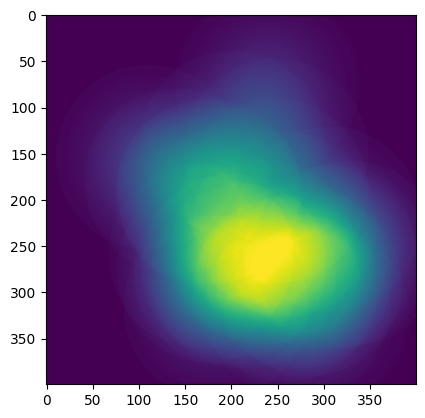

In [7]:
# test this

import matplotlib.pyplot as plt

mask = combi_df.mask_normalized[20]
plt.imshow(mask)

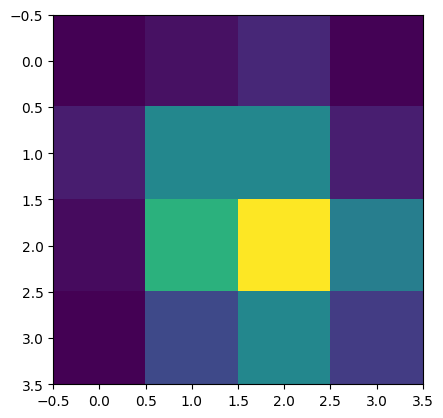

In [8]:
plt.imshow(downsample(mask))

In [9]:
np.sum(downsample(mask))

1.0

Downsample all masks (normalized)

In [10]:
combi_df['mask_normalized_downsampled'] = [downsample(mask) for mask in combi_df['mask_normalized']]

In [11]:
combi_df

,filename,img_path,mask_normalized,caption,foil,nr_clicks,linguistic_phenomena,points_clicked,total_clicks,mask_normalized_downsampled
0,000000001584.jpg,../VALSE_data/images/coco2017/000000001584.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","The red, double decker bus is driving past oth...","The red, double decker bus is driving towards ...","[4, 2, 2]",relations,"[(100, 204), (344, 270), (52, 228), (392, 227)...",8,"[[0.0, 0.0, 0.0, 0.0], [0.041735509019357464, ..."
1,000000005529.jpg,../VALSE_data/images/coco2017/000000005529.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",A person on skis is skiing down a snowy hill.,A person on skis is skiing up a snowy hill.,"[4, 2, 2, 3]",relations,"[(180, 246), (187, 201), (106, 258), (182, 107...",11,"[[0.004637486872034835, 0.08598791735613415, 0..."
2,000000021903.jpg,../VALSE_data/images/coco2017/000000021903.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",A man reaches out to give the elephant something.,A man reaches inside to give the elephant some...,"[4, 3, 3, 2]",relations,"[(171.5, 230), (223.5, 238), (171.5, 214), (12...",12,"[[0.0, 0.0, 0.0, 0.0], [0.006853082493612227, ..."
3,000000027620.jpg,../VALSE_data/images/coco2017/000000027620.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",The laptop was left open on the desk.,The laptop was left open under the desk.,"[5, 4, 3]",relations,"[(146.5, 250), (295.5, 168), (45.5, 109), (306...",12,"[[0.02402860485782861, 0.08117804066081269, 0...."
4,000000033368.jpg,../VALSE_data/images/coco2017/000000033368.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",A tennis player is standing on the court.,A tennis player is standing off the court.,"[1, 4, 4]",relations,"[(200.39996337890625, 126.19999694824219), (18...",9,"[[0.0004019301308121526, 0.07011470098163962, ..."
...,...,...,...,...,...,...,...,...,...,...
87,v7w_2402139.jpg,../VALSE_data/images/v7w/v7w_2402139.jpg,"[[5.392276262310973e-06, 5.500667944166996e-06...",There are no clouds in the sky.,There is at least one cloud in the sky.,"[3, 6, 6]",existence,"[(176.5, 136), (237.5, 80), (77.5, 47), (352, ...",15,"[[0.12968301946508318, 0.13383780314422625, 0...."
88,v7w_2407816.jpg,../VALSE_data/images/v7w/v7w_2407816.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",There is at least one power line.,There are no power lines.,"[5, 4, 4, 7]",existence,"[(196.5, 229), (344.5, 289), (47.5, 202), (354...",20,"[[0.0, 0.0, 0.0, 0.0], [0.01991317654765427, 0..."
89,v7w_2411632.jpg,../VALSE_data/images/v7w/v7w_2411632.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",There are no people in the photo.,There is at least one person in the photo.,"[5, 9, 10, 10, 7]",existence,"[(224.5, 249), (245.5, 343), (248.5, 349), (16...",41,"[[7.25101021142701e-07, 0.006881846083901585, ..."
90,v7w_2411942.jpg,../VALSE_data/images/v7w/v7w_2411942.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",There is at least one zebra in the picture.,There are no zebras in the picture.,"[4, 3, 2, 2]",existence,"[(172, 200), (316, 307), (245, 150), (192, 165...",11,"[[0.0, 0.011911686831679532, 0.043987085555803..."


# Export

In [12]:
combi_df.to_pickle("3_combined_masks.pickle")

In [13]:
combi_df['linguistic_phenomena'].value_counts()

linguistic_phenomena
actions      32
existence    32
relations    28
Name: count, dtype: int64